In [18]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

In [19]:
# acuracy = measures the proportion of correctly classified instances (both positive and negative) relative to the total number of instances
# useful when classes are balanced 
# in highly imbalanced datasets, accuracy can be misleading as the model may simply favor the majority class
# (tp + tn) / (tp + tn + fp + fn)

# precision = indicates how many of the instances predicted as positive are actually positive
# Anteil der korrekt vorhergesagten positiven Fälle unter allen vorhergesagten positiven Fällen
# crucial when cost of false positives is high( f.e. disease detection) where a positive test result may trigger expensive treatments
# tp divided by number of all predictions also tp / (tp + fp)


# false positive rate fpr = fp / (tn + fp)
# true positive rate tpr = tp / (fn + tp)

# recall = measures how many of the actual positive instances are correctly identified by the model
# Anteil korrekt vorhergesagten positiven Fälle unter allen tatsächlichen positiven Fällen

# important when identifying as many positive cases as possible is crucial, such as in fraud detection
# tp : (number of positive observations also tp / (tp + fn)

# f1-score
# The F1-Score is the harmonic mean of precision and recall
# useful when you need to balance precision and recall

# AUC (Area Under the Curve)
# measures area under the ROC curve (Receiver Operating Characteristic)
# representing model’s ability to distinguish between positive and negative classes
# 0.5 ≤ AUC ≤ 1
# 0.5 means the model is no better than random guessing
# AUC of 1 represents perfect separation between classes
# AUC is independent of any specific threshold and evaluates model performance across all thresholds

In [20]:
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
response = requests.get(url)

# zip-data
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # open "bank.zip"
    with z.open("bank.zip") as inner_zip:
        # open inner ZIP (bank.zip)
        with zipfile.ZipFile(inner_zip) as bank_zip:
            # open "bank-full.csv" data from "bank.zip"
            with bank_zip.open("bank-full.csv") as csv_file:
                # reading
                df = pd.read_csv(csv_file, sep=";")
                
# show
df.tail(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [40]:
# cleaning
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# finding which of them has missung values
missing_values = df.isnull().sum()
columns_with_missing = missing_values[missing_values > 0].index.tolist()

if columns_with_missing:
    print(f"These columns have missing values: {', '.join(columns_with_missing)}")
else:
    print("No columns have missing values.")

No columns have missing values.


In [22]:
columns = [
'age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

df_selected = df [columns]

In [23]:
# splitting df
df_full_train, df_test = train_test_split(df_selected, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [24]:
# turning y into numerical value
y_train = df_train['y'].map({'yes': 1, 'no': 0}).values
y_val = df_val['y'].map({'yes': 1, 'no': 0}).values
y_test = df_test['y'].map({'yes': 1, 'no': 0}).values

# deleting y to avoind leaking
del df_train['y']
del df_val['y']
del df_test['y']

In [25]:
# Question 1

In [26]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [29]:
# dictionary for saving auc variables
auc_scores = {}

# calculating auc for num variable
for var in numerical:
    auc = roc_auc_score(y_train, df_train[var])
    
    # if auc smaller 0.5, inverting var
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    
    # saving in dic
    auc_scores[var] = auc

# sorting auc scores by value, highest first
sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

# print variable, auc rounded to 3 decimal
for var, auc in sorted_auc:
    print(f"Variable: {var}, AUC: {round(auc, 3)}")

# print
print(f"Variable with highest AUC is: {sorted_auc[0][0]} with AUC-value: {round(sorted_auc[0][1], 3)}")

Variable: duration, AUC: 0.815
Variable: previous, AUC: 0.599
Variable: pdays, AUC: 0.59
Variable: balance, AUC: 0.589
Variable: campaign, AUC: 0.571
Variable: day, AUC: 0.526
Variable: age, AUC: 0.512
Variable with highest AUC is: duration with AUC-value: 0.815


In [12]:
# Question 2

In [30]:
# combining cat and num in one dict
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# applying one hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

# logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# val set
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# calculating positive pred and auc
y_pred = model.predict_proba(X_val)[:, 1]  
auc = roc_auc_score(y_val, y_pred)

# print
print(f"AUC: {auc:.3f}")

AUC: 0.900


In [14]:
# Question 3

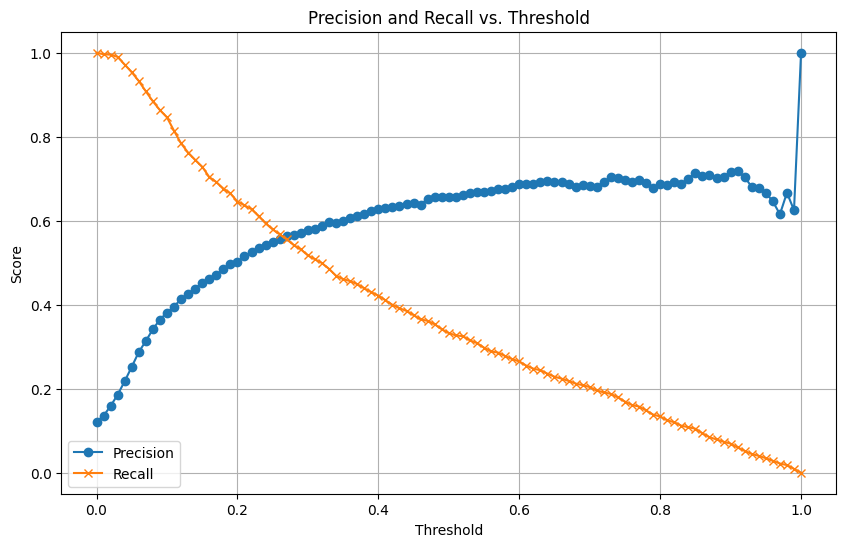

In [31]:
# prediction probabilities for positive class
y_scores = model.predict_proba(X_val)[:, 1]

# thresholds from 0.0 till 1.0 in steps of 0.01
thresholds = np.linspace(0, 1, 101)

precision = []
recall = []

# calculating precision and recall for every threshold
for threshold in thresholds:
    # binary pred based on treshold
    y_pred = (y_scores >= threshold).astype(int)
    
    # calculating
    precision.append(precision_score(y_val, y_pred, zero_division=1))
    recall.append(recall_score(y_val, y_pred))

# plotting precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision', marker='o')
plt.plot(thresholds, recall, label='Recall', marker='x')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()

In [32]:
# find threshold where precision and recall cross
precision = np.array(precision)
recall = np.array(recall)
diff = np.abs(precision - recall)  
min_diff_index = np.argmin(diff) 
best_threshold = thresholds[min_diff_index]

print(f"Threshold at which Precision and Recall intersect: {best_threshold:.3f}")

Threshold at which Precision and Recall intersect: 0.270


In [33]:
# Question 4

Threshold with maximal F1 score: 0.220
Maximal F1 score: 0.572


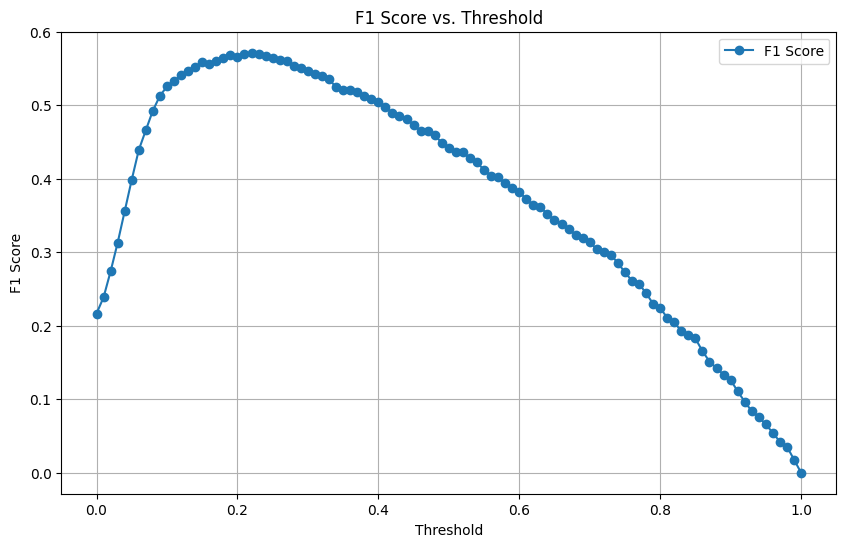

In [34]:
# calculate f1 score for each threshold
f1_scores = []

for threshold in thresholds:
    # binary predictions based on the threshold
    y_pred = (y_scores >= threshold).astype(int)
    
    # calculate precision, recall, and f1
    p = precision_score(y_val, y_pred, zero_division=1)
    r = recall_score(y_val, y_pred)
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

# convert f1 scores to a numpy array
f1_scores = np.array(f1_scores)

# determine the threshold at which the f1 score is maximal
max_f1_index = np.argmax(f1_scores)
best_f1_threshold = thresholds[max_f1_index]

print(f"Threshold with maximal F1 score: {best_f1_threshold:.3f}")
print(f"Maximal F1 score: {f1_scores[max_f1_index]:.3f}")

# plot the f1 score over the thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid()
plt.show()

In [35]:
# Question 5

In [37]:
# combine categorical and numerical variables
train_dict = df_full_train[categorical + numerical].to_dict(orient='records')

# one-hot-encoding
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(train_dict)

# target variable
y = df_full_train['y'].map({'yes': 1, 'no': 0}).values

# k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_index, val_index in kf.split(X):
    # split into train and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # model training
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # predictions for the validation dataset
    y_pred = model.predict_proba(X_val)[:, 1]

    # calculate auc
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

# output the AUC values for each fold
for i, score in enumerate(auc_scores):
    print(f"Fold {i + 1}: AUC = {score:.3f}")

# average auc over all folds
mean_auc = np.mean(auc_scores)
print(f"Average AUC over all folds: {mean_auc:.3f}")

# calculate the standard deviation of auc values
std_auc = np.std(auc_scores)
print(f"Standard deviation of AUC values: {std_auc:.3f}")

Fold 1: AUC = 0.899
Fold 2: AUC = 0.899
Fold 3: AUC = 0.911
Fold 4: AUC = 0.908
Fold 5: AUC = 0.912
Average AUC over all folds: 0.906
Standard deviation of AUC values: 0.006


In [38]:
# Question 6

In [39]:
# combine categorical and numerical variables
train_dict = df_full_train[categorical + numerical].to_dict(orient='records')

# one-hot-encoding
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(train_dict)

# target variable
y = df_full_train['y'].map({'yes': 1, 'no': 0}).values

# k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# list of c values to be tested
C_values = [0.000001, 0.001, 1]

# saving results
results = {}

for C in C_values:
    # list to store AUC values for each c value
    auc_scores = []  
    
    for train_index, val_index in kf.split(X):
        # split into train and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # train model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # predictions for the validation dataset
        y_pred = model.predict_proba(X_val)[:, 1]

        # calculate auc
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)  

    # calculate mean and standard deviation for the current c value
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # save
    results[C] = (round(mean_auc, 3), round(std_auc, 3))

# print
for C, (mean, std) in results.items():
    print(f"C = {C}: Mean AUC = {mean}, Std AUC = {std}")

# find best c
best_C = max(results, key=lambda k: results[k][0])
best_mean_auc = results[best_C][0]

print(f"\nBest C value: {best_C} with Mean AUC: {best_mean_auc}")

C = 1e-06: Mean AUC = 0.701, Std AUC = 0.009
C = 0.001: Mean AUC = 0.861, Std AUC = 0.007
C = 1: Mean AUC = 0.906, Std AUC = 0.006

Best C value: 1 with Mean AUC: 0.906
